In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

Train Data


In [6]:
#Path of the CSV file
train_dataset=(r"C:\Users\91979\Downloads\nikesh\projects\microsoft\GUIDE_Train.csv")

# Define a function to optimize memory usage

data_chunks = []

def load_and_optimize(train_dataset, chunksize=500000):
    for chunk in pd.read_csv(train_dataset, chunksize=chunksize, low_memory=False):
        
        # Downcast integer columns
        for col in chunk.select_dtypes(include=['int64']).columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        
        # Downcast float columns
        for col in chunk.select_dtypes(include=['float64']).columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')
        
        # Convert object columns to categories
        for col in chunk.select_dtypes(include=['object']).columns:
            chunk[col] = chunk[col].astype('category')
        
        
        data_chunks.append(chunk)
load_and_optimize(train_dataset, chunksize=500000)

train_data = pd.concat(data_chunks, ignore_index=True)

train_data.head()


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [8]:
# size of the dataset
train_data.shape

(9516837, 45)

In [9]:
train_data.columns # columns in the dataset

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [10]:
train_data.info() # information about the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [11]:
train_data.describe() # summary of the dataset

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


Handling Missing Values

In [12]:
train_data.isnull().sum() # check for missing values

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [13]:
#dropping columns having more than 50% missing values

train_data = train_data.dropna(thresh=train_data.shape[0]*0.5,axis=1)

train_data.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade         51340
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
dtype: int64

In [14]:
#Dropping rows with missing values
train_data = train_data.dropna(subset=["IncidentGrade"])

In [15]:
train_data.isnull().sum() # check for missing values

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [16]:
#duplicate rows
print(train_data.duplicated().sum())

542692


In [17]:
#dropping duplicate rows
train_data = train_data.drop_duplicates()

print("Number of rows after dropping duplicates: ", train_data.shape[0])

train_data.shape

Number of rows after dropping duplicates:  8922805


(8922805, 35)

In [18]:
#Feature Engineering
# Convert Timestamp to datetime and extract date parts
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], errors='coerce')  # Convert to datetime format

# Extract year, month, day, hour, and day of week as new columns
train_data['year'] = train_data['Timestamp'].dt.year
train_data['month'] = train_data['Timestamp'].dt.month
train_data['day'] = train_data['Timestamp'].dt.day
train_data['hour'] = train_data['Timestamp'].dt.hour


# Drop the original Timestamp column
train_data= train_data.drop(columns=['Timestamp'])


EXPLORATORY DATA ANALYSIS(DATA VISUALIZATION)

In [19]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    3827800
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

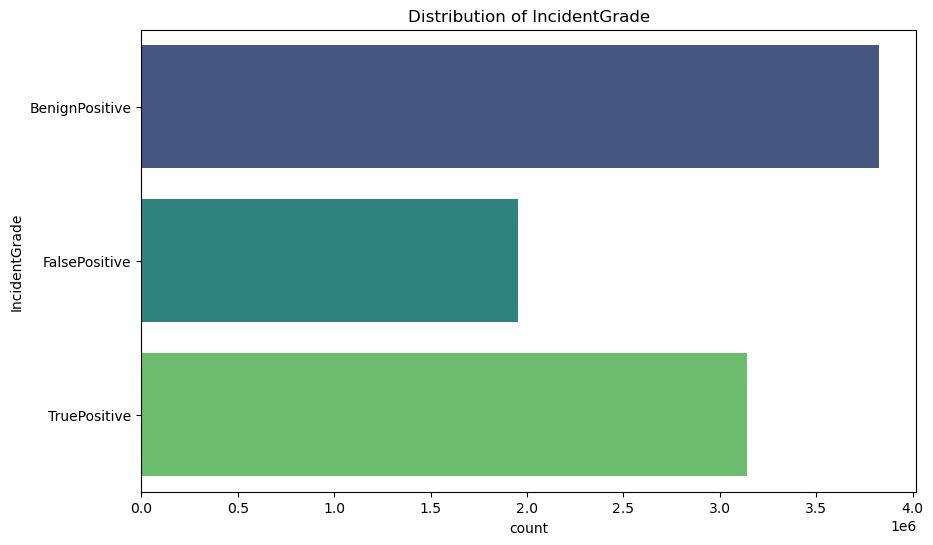

In [20]:
#plotting the distribution of the target variable with differnt colours

plt.figure(figsize=(10,6))
sns.countplot(train_data['IncidentGrade'], palette='viridis')
plt.title('Distribution of IncidentGrade')
plt.show()

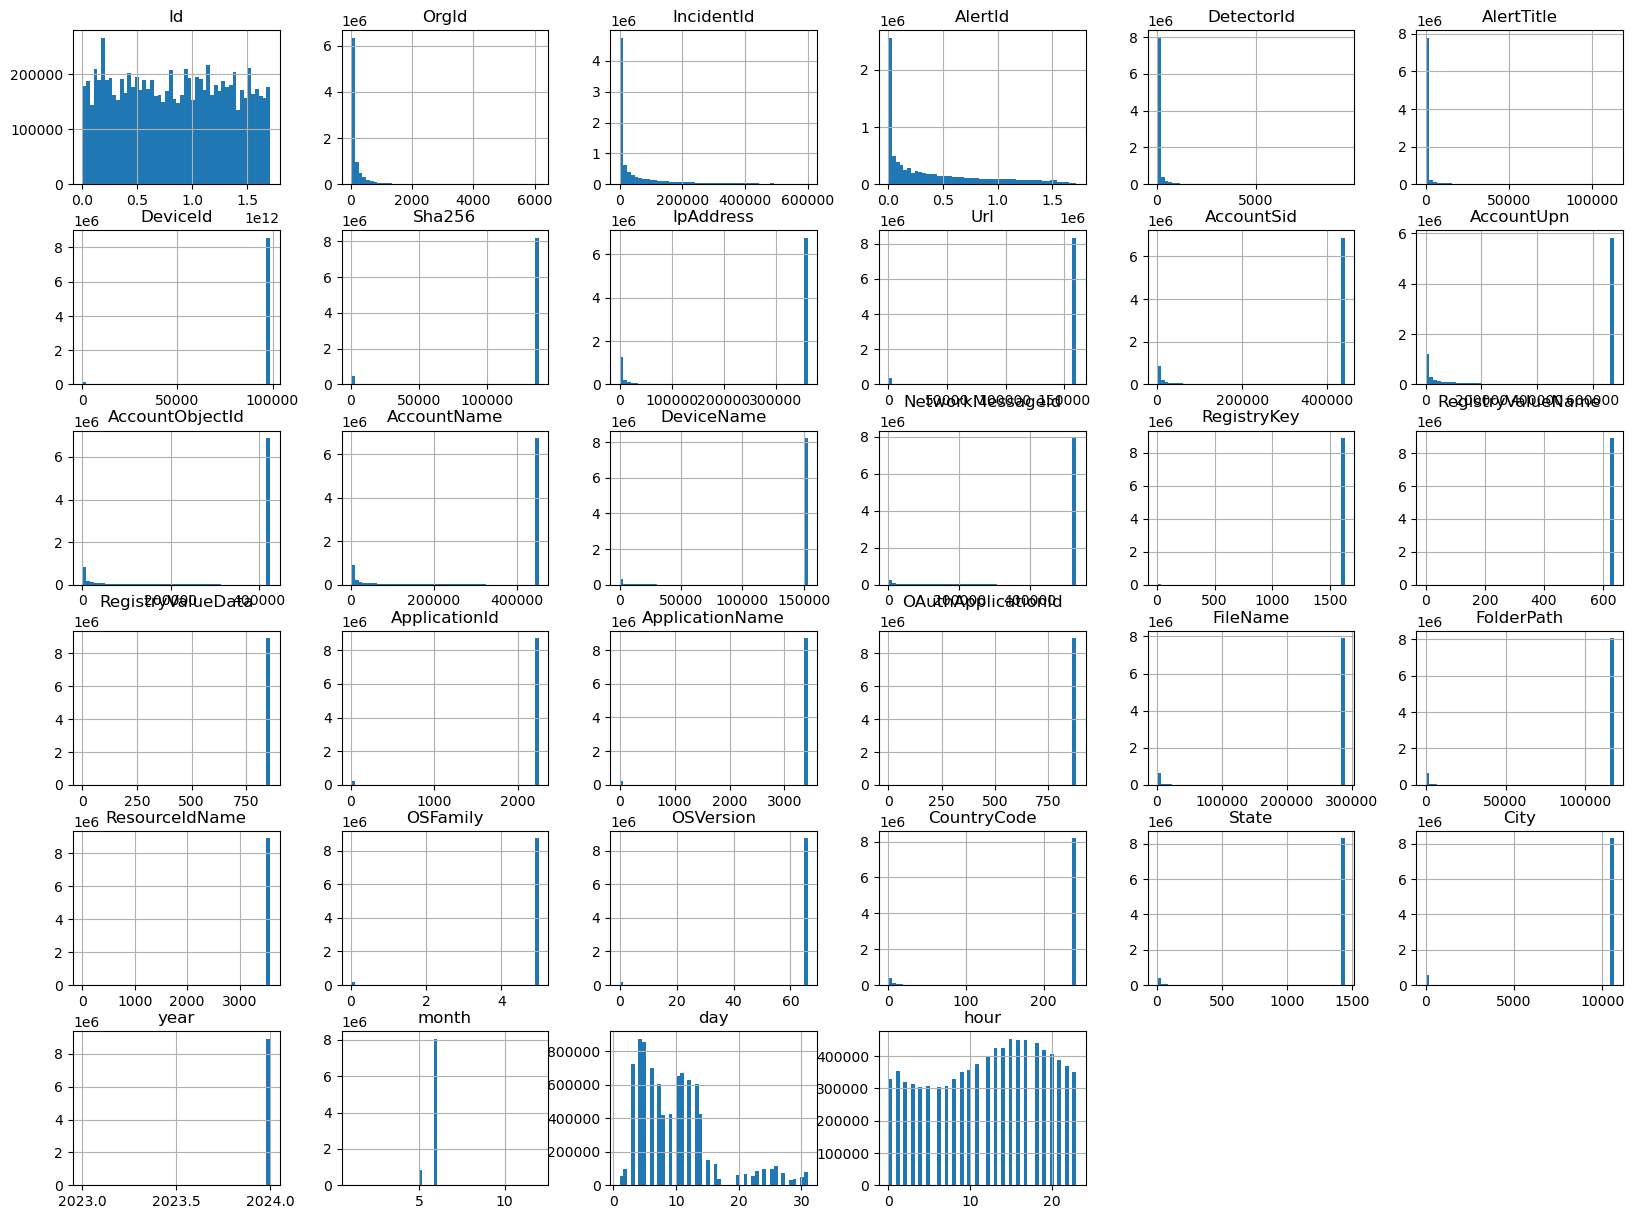

In [21]:
# plot the distribution
train_data.hist(bins=50, figsize=(20,15))
plt.show()

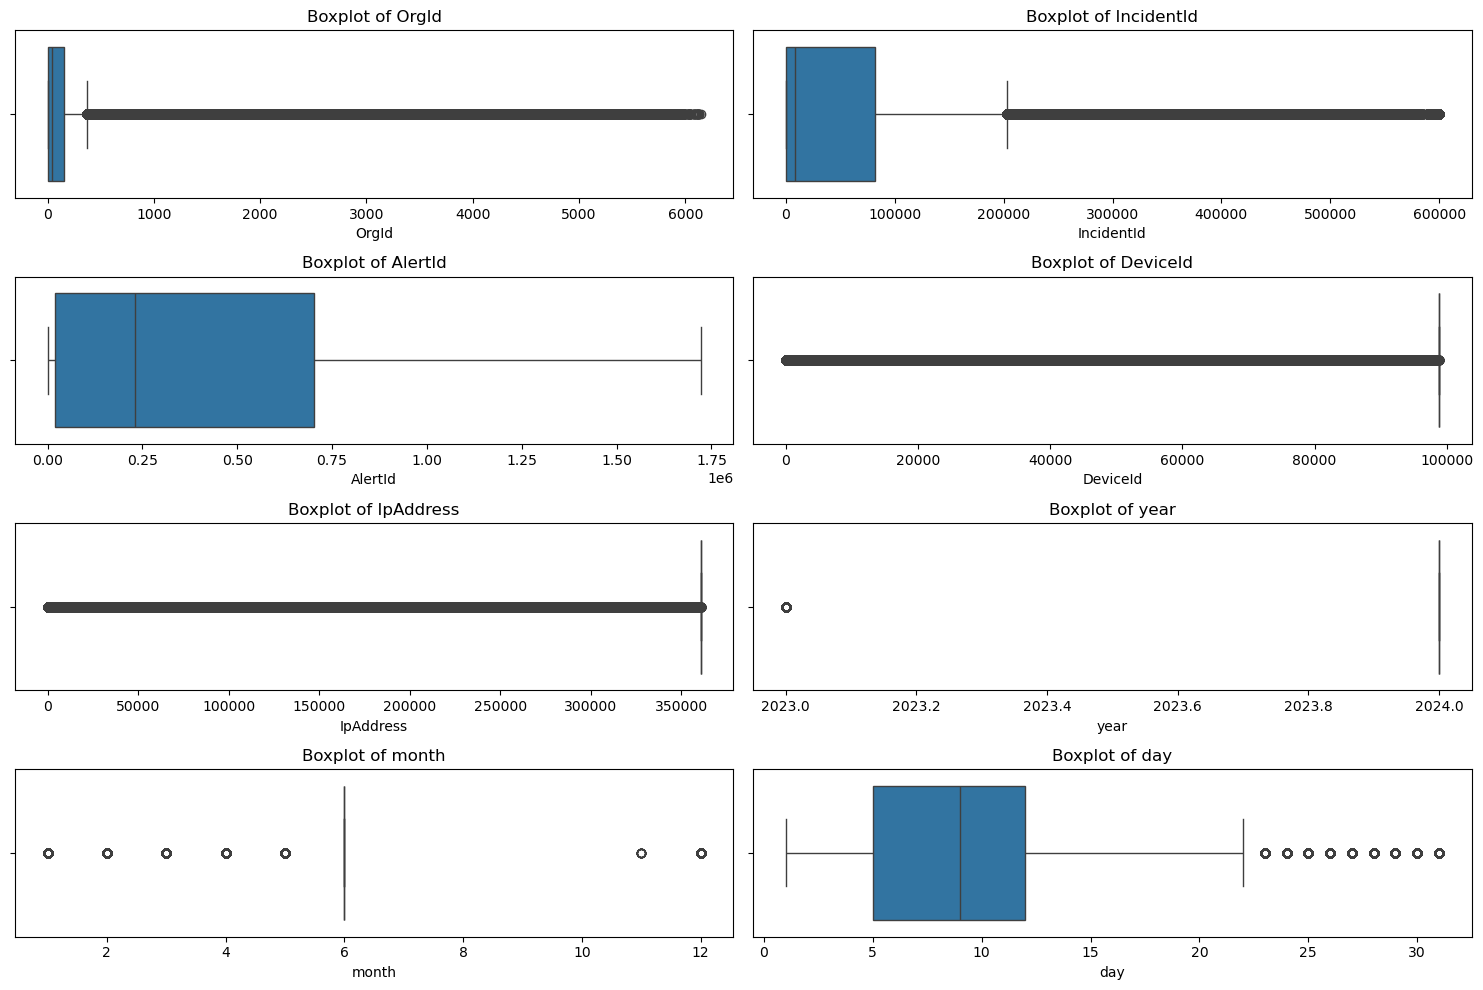

In [22]:
#plotting boxplot for outliers
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'year', 'month', 'day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [23]:
# Corelation matrix
numeric_cols = train_data.select_dtypes(include=[np.number])


correlation_matrix = numeric_cols.corr()


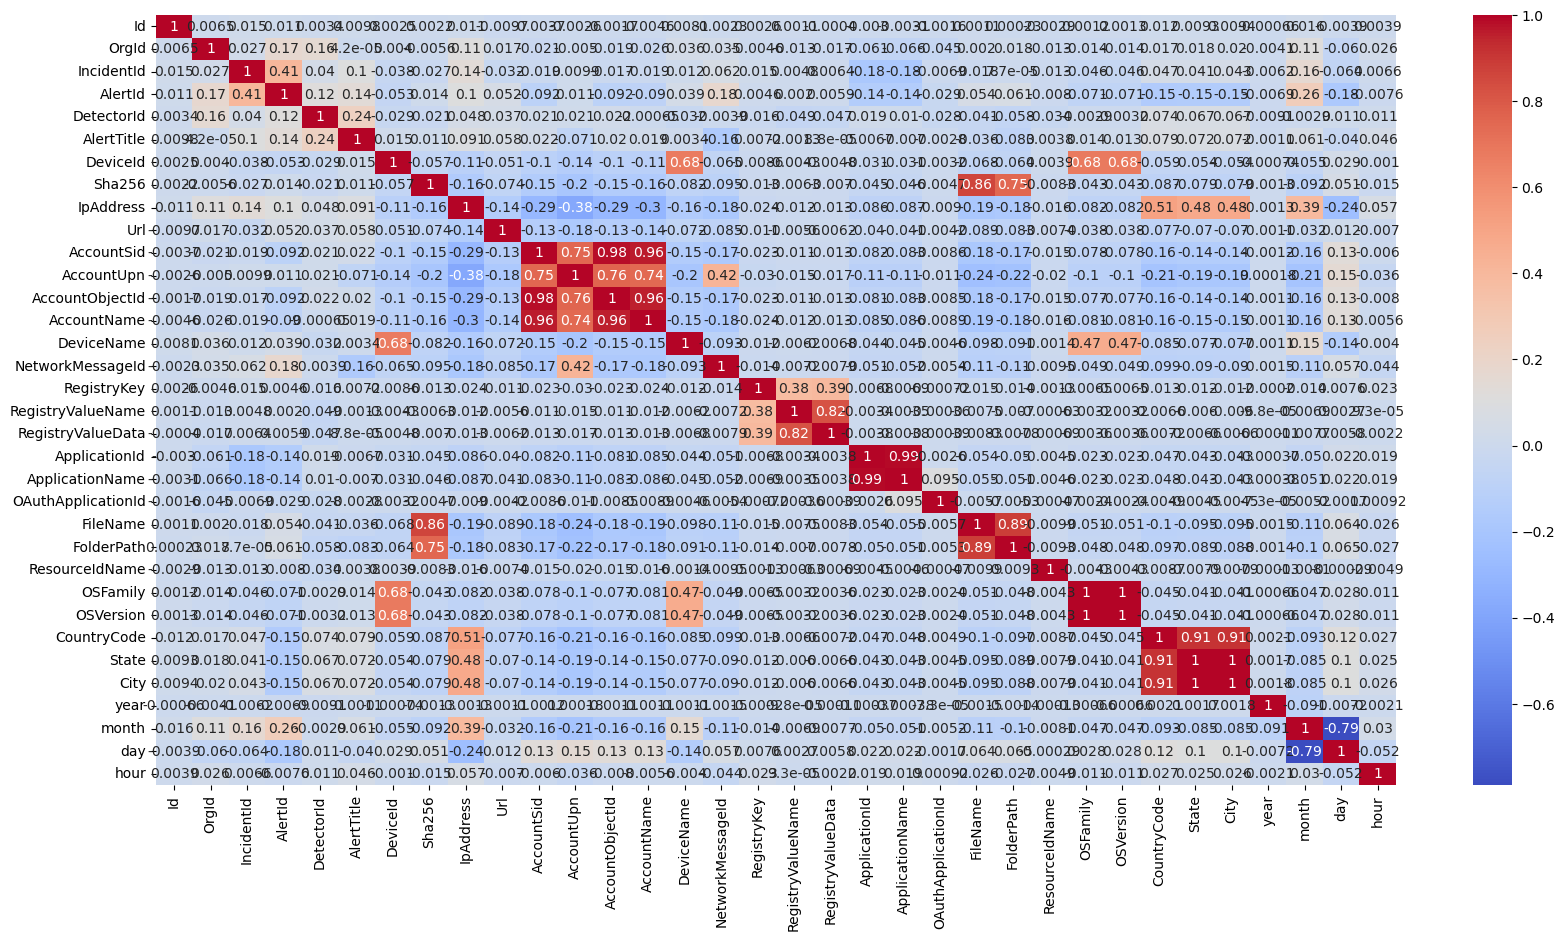

In [24]:
#plotting corelation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()



Feature importance

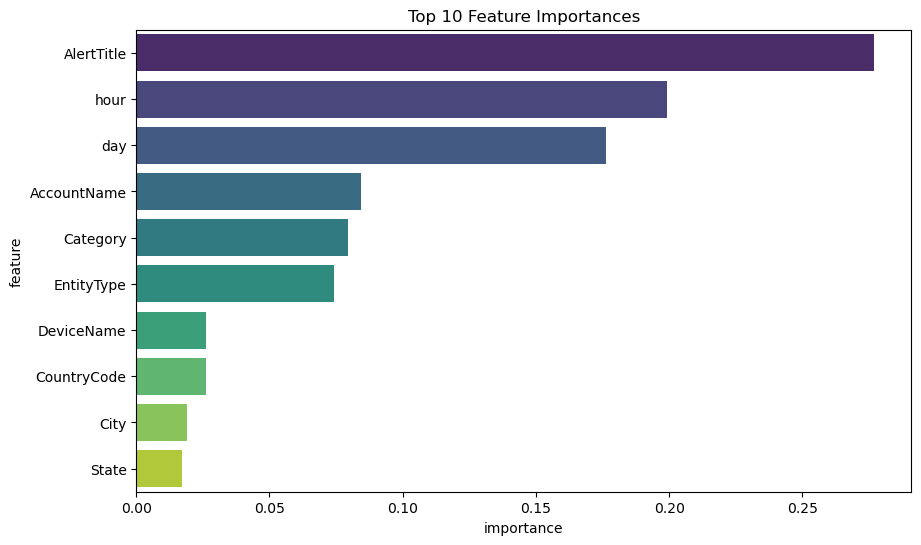

In [25]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']
train_sample = train_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10),palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

In [26]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [27]:
columns_to_drop = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256','IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId','BlockingIOErrorDeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [28]:
print(train_data.columns)

print(train_data.shape)
train_data.head()

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City',
       'year', 'month', 'day', 'hour'],
      dtype='object')
(8922805, 15)


,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,AccountName,DeviceName,OSFamily,CountryCode,State,City,year,month,day,hour
0,6,InitialAccess,TruePositive,Ip,Related,453297,153085,5,31,6,3,2024,6,4,6
1,43,Exfiltration,FalsePositive,User,Impacted,24887,153085,5,242,1445,10630,2024,6,14,3
2,298,InitialAccess,FalsePositive,Url,Related,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,453297,153085,5,242,1445,10630,2024,6,10,16
4,74,Execution,TruePositive,User,Impacted,479,153085,5,242,1445,10630,2024,6,15,1


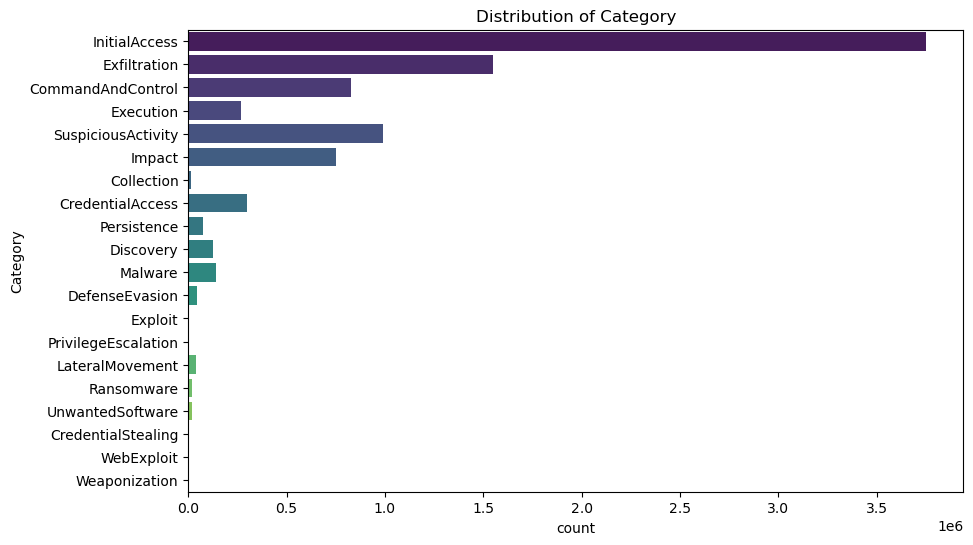

In [29]:
#plotting the distribution of category
plt.figure(figsize=(10,6))
sns.countplot(train_data['Category'], palette='viridis')
plt.title('Distribution of Category')
plt.show()

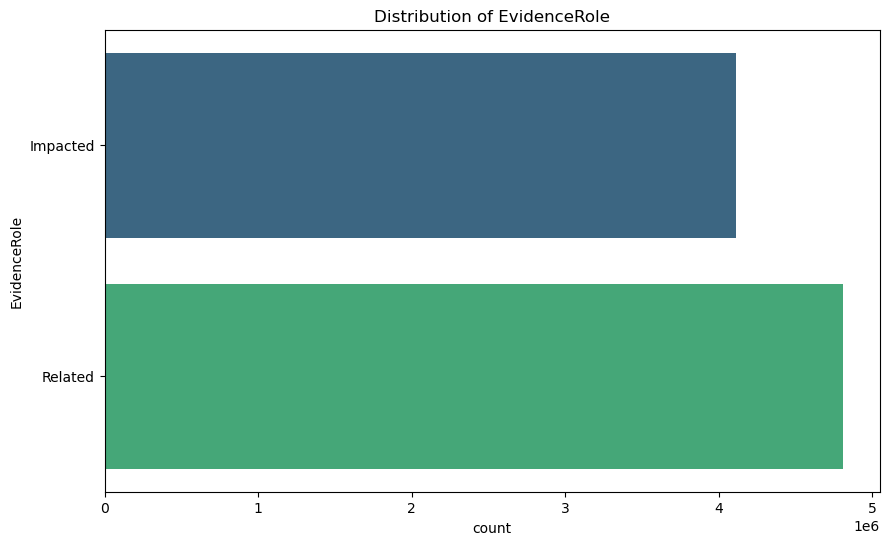

In [30]:
#plotting the distribution of evidence Role
plt.figure(figsize=(10,6))
sns.countplot(train_data['EvidenceRole'], palette='viridis')
plt.title('Distribution of EvidenceRole')
plt.show()

In [31]:
# Columns to drop based on correlation and feature importance
columns_to_drop = ['City', 'State'] 

# Drop selected columns
train_data = train_data.drop(columns=columns_to_drop)

print("Dropped columns due to high correlation and lower feature importance:", columns_to_drop)


Dropped columns due to high correlation and lower feature importance: ['City', 'State']


In [32]:
train_data.head() # first 5 rows of the dataset


,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour
0,6,InitialAccess,TruePositive,Ip,Related,453297,153085,5,31,2024,6,4,6
1,43,Exfiltration,FalsePositive,User,Impacted,24887,153085,5,242,2024,6,14,3
2,298,InitialAccess,FalsePositive,Url,Related,453297,153085,5,242,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,453297,153085,5,242,2024,6,10,16
4,74,Execution,TruePositive,User,Impacted,479,153085,5,242,2024,6,15,1


In [33]:
print(train_data.shape) # shape of the dataset

(8922805, 13)


In [34]:
train_data.nunique() # unique values in each column

AlertTitle        79952
Category             20
IncidentGrade         3
EntityType           33
EvidenceRole          2
AccountName      363254
DeviceName       114267
OSFamily              6
CountryCode         236
year                  2
month                 8
day                  31
hour                 24
dtype: int64

In [35]:
train_data['Category'].value_counts() # value counts of the category column

Category
InitialAccess          3752038
Exfiltration           1550701
SuspiciousActivity      992318
CommandAndControl       825580
Impact                  750847
CredentialAccess        297572
Execution               266733
Malware                 140821
Discovery               127918
Persistence              72444
DefenseEvasion           46224
LateralMovement          40103
UnwantedSoftware         18005
Ransomware               17377
Collection               14446
PrivilegeEscalation       4665
Exploit                   4583
CredentialStealing         386
WebExploit                  38
Weaponization                6
Name: count, dtype: int64

In [36]:
train_data['EvidenceRole'].value_counts() # value counts of the EvidenceRole column

EvidenceRole
Related     4808045
Impacted    4114760
Name: count, dtype: int64

In [37]:
train_data['EntityType'].value_counts() # value counts of the EntityType column

EntityType
Ip                       2174998
User                     1879451
MailMessage              1004821
Machine                   696472
File                      682079
CloudLogonRequest         632503
Url                       589305
Mailbox                   345494
Process                   345069
CloudApplication          216797
CloudLogonSession         210556
MailCluster               106784
RegistryValue              11209
AzureResource               8100
RegistryKey                 7277
GenericEntity               4294
OAuthApplication            2595
Malware                     2580
SecurityGroup               1507
BlobContainer                306
Blob                         263
MailboxConfiguration         226
Nic                           49
IoTDevice                     31
ActiveDirectoryDomain         11
GoogleCloudResource           10
AmazonResource                 6
Container                      2
KubernetesCluster              2
ContainerImage                 2

In [38]:
#Capping outliers using quantiles and log transformation

def handle_outliers(df):
    # Define columns where quantile capping will be applied
    capped_columns = ['AlertId']
    
    # Check if columns exist before applying quantile capping
    for col in capped_columns:
        if col in df.columns:
            q_low = df[col].quantile(0.01)
            q_high = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=q_low, upper=q_high)
    
    # Optional log transformation for skewed fields, if needed
    for col in capped_columns:
        if col in df.columns and df[col].skew() > 1:
            df[col] = np.log1p(df[col])  # log1p to handle zero values safely
            
    return df

# Apply outlier handling
train_data = handle_outliers(train_data)


In [39]:


# Identify categorical columns
categorical_columns = ['IncidentGrade', 'EvidenceRole', 'Category', 'EntityType']

# Check if columns exist before applying one-hot encoding
columns_to_encode = [col for col in ['Category', 'EntityType', 'EvidenceRole'] if col in train_data.columns]

# Apply one-hot encoding or label encoding only to categorical columns
# One-hot encoding for non-ordinal categorical columns
if columns_to_encode:
	train_data = pd.get_dummies(train_data, columns=columns_to_encode, drop_first=True)

# Label encoding for ordinal categorical column if it has an order
if 'IncidentGrade' in train_data.columns:
	le = LabelEncoder()
	train_data['IncidentGrade'] = le.fit_transform(train_data['IncidentGrade'])


# Apply frequency encoding only to high-cardinality categorical features
frequency_encoding = train_data['AlertTitle'].value_counts(normalize=True)
train_data['AlertTitle_encoded'] = train_data['AlertTitle'].map(frequency_encoding)

# Now train_data has encoded categorical columns, and numerical columns are untouched
train_data.head()


,AlertTitle,IncidentGrade,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour,...,EntityType_Nic,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Related,AlertTitle_encoded
0,6,2,453297,153085,5,31,2024,6,4,6,...,False,False,False,False,False,False,False,False,True,0.033970
1,43,1,24887,153085,5,242,2024,6,14,3,...,False,False,False,False,False,False,False,True,False,0.002686
2,298,1,453297,153085,5,242,2024,6,13,4,...,False,False,False,False,False,False,True,False,True,0.000228
3,2,0,453297,153085,5,242,2024,6,10,16,...,False,False,False,False,False,False,True,False,True,0.066846
4,74,2,479,153085,5,242,2024,6,15,1,...,False,False,False,False,False,False,False,True,False,0.001106


In [40]:
#Saving the cleaned dataset as joblib file
import joblib
joblib.dump(train_data, 'encoded_train_data.joblib')
print("Data cleaning completed and saved as encoded_train_data.joblib")

Data cleaning completed and saved as encoded_train_data.joblib


In [41]:
#Loading the cleaned dataset
train_data = joblib.load('encoded_train_data.joblib')
train_data.head()

,AlertTitle,IncidentGrade,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour,...,EntityType_Nic,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Related,AlertTitle_encoded
0,6,2,453297,153085,5,31,2024,6,4,6,...,False,False,False,False,False,False,False,False,True,0.033970
1,43,1,24887,153085,5,242,2024,6,14,3,...,False,False,False,False,False,False,False,True,False,0.002686
2,298,1,453297,153085,5,242,2024,6,13,4,...,False,False,False,False,False,False,True,False,True,0.000228
3,2,0,453297,153085,5,242,2024,6,10,16,...,False,False,False,False,False,False,True,False,True,0.066846
4,74,2,479,153085,5,242,2024,6,15,1,...,False,False,False,False,False,False,False,True,False,0.001106


Test Data

In [42]:
#Loading the test dataset
data_chunks = []
test_dataset = (r"C:\Users\91979\Downloads\nikesh\projects\microsoft\GUIDE_Test.csv")
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    # Downcast integer columns
    for col in chunk.select_dtypes(include=['int64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
    
    # Downcast float columns
    for col in chunk.select_dtypes(include=['float64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='float')
    
    # Convert object columns to categories
    for col in chunk.select_dtypes(include=['object']).columns:
        chunk[col] = chunk[col].astype('category')
    
    data_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
test_data = pd.concat(data_chunks, ignore_index=True)

# Clean up memory
del data_chunks

In [43]:
test_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [44]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

In [45]:
test_data.info()    # information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       category
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [46]:
test_data.describe() # summary of the dataset

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,...,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06
mean,8.462250e+11,1.756698e+02,6.780345e+04,4.072191e+05,1.008391e+02,2.529514e+03,9.575061e+04,1.283939e+05,2.873898e+05,1.504279e+05,...,3.342993e+03,8.808119e+02,2.618998e+05,1.074020e+05,3.583541e+03,4.899529e+00,6.466873e+01,2.222218e+02,1.344570e+03,9.883839e+03
std,4.923351e+11,3.708729e+02,1.178736e+05,4.550578e+05,4.082934e+02,1.044138e+04,1.615628e+04,3.457595e+04,1.400920e+05,3.734754e+04,...,5.096996e+02,1.238317e+01,8.208434e+04,3.260346e+04,9.012124e+01,7.001299e-01,9.269678e+00,6.499822e+01,3.626851e+02,2.696302e+03
min,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,8.000000e+00,4.110000e+02,2.365900e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.300000e+01,8.818000e+03,2.228970e+05,7.000000e+00,9.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.730000e+02,7.944000e+04,6.711010e+05,3.900000e+01,1.160000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.138000e+03,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [47]:
test_data.isnull().sum() # check for missing values

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [48]:
#dropping columns having more than 50% missing values

test_data = test_data.dropna(thresh=test_data.shape[0]*0.5,axis=1)

test_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Usage                 0
dtype: int64

In [49]:
#duplicate rows
print(test_data.duplicated().sum())


225297


In [50]:
#dropping duplicate rows
test_data = test_data.drop_duplicates()

print("Number of rows after dropping duplicates: ", test_data.shape[0])

Number of rows after dropping duplicates:  3922695


In [51]:
#dropping the usage column since it is not present in the train dataset and doesnt provide any useful information
test_data = test_data.drop(columns=['Usage'], errors='ignore')

In [52]:
#Feature Engineering
# Convert Timestamp to datetime and extract date parts
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], errors='coerce')  # Convert to datetime

# Extract year, month, day, hour, and day of week as new columns
test_data['year'] = test_data['Timestamp'].dt.year
test_data['month'] = test_data['Timestamp'].dt.month
test_data['day'] = test_data['Timestamp'].dt.day
test_data['hour'] = test_data['Timestamp'].dt.hour

# Drop the original Timestamp column
test_data = test_data.drop(columns=['Timestamp'])


In [53]:
test_data.columns


Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'year', 'month', 'day', 'hour'],
      dtype='object')

EXPLORATORY DATA ANALYSIS(TEST DATA)

In [54]:
#values of the target variable
test_data['IncidentGrade'].value_counts()


IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

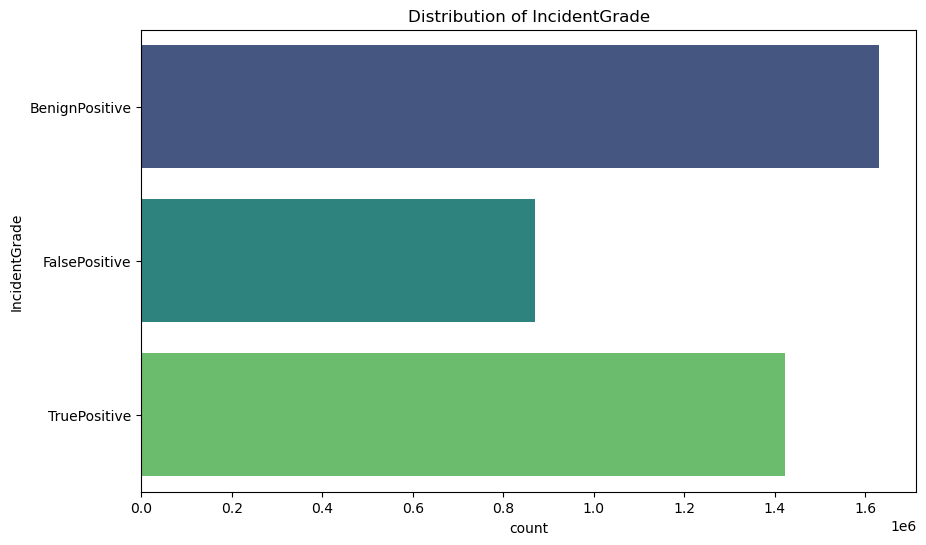

In [55]:
#plotting the distribution of the target variable with differnt colours
plt.figure(figsize=(10,6))
sns.countplot(test_data['IncidentGrade'], palette='viridis')
plt.title('Distribution of IncidentGrade')
plt.show()

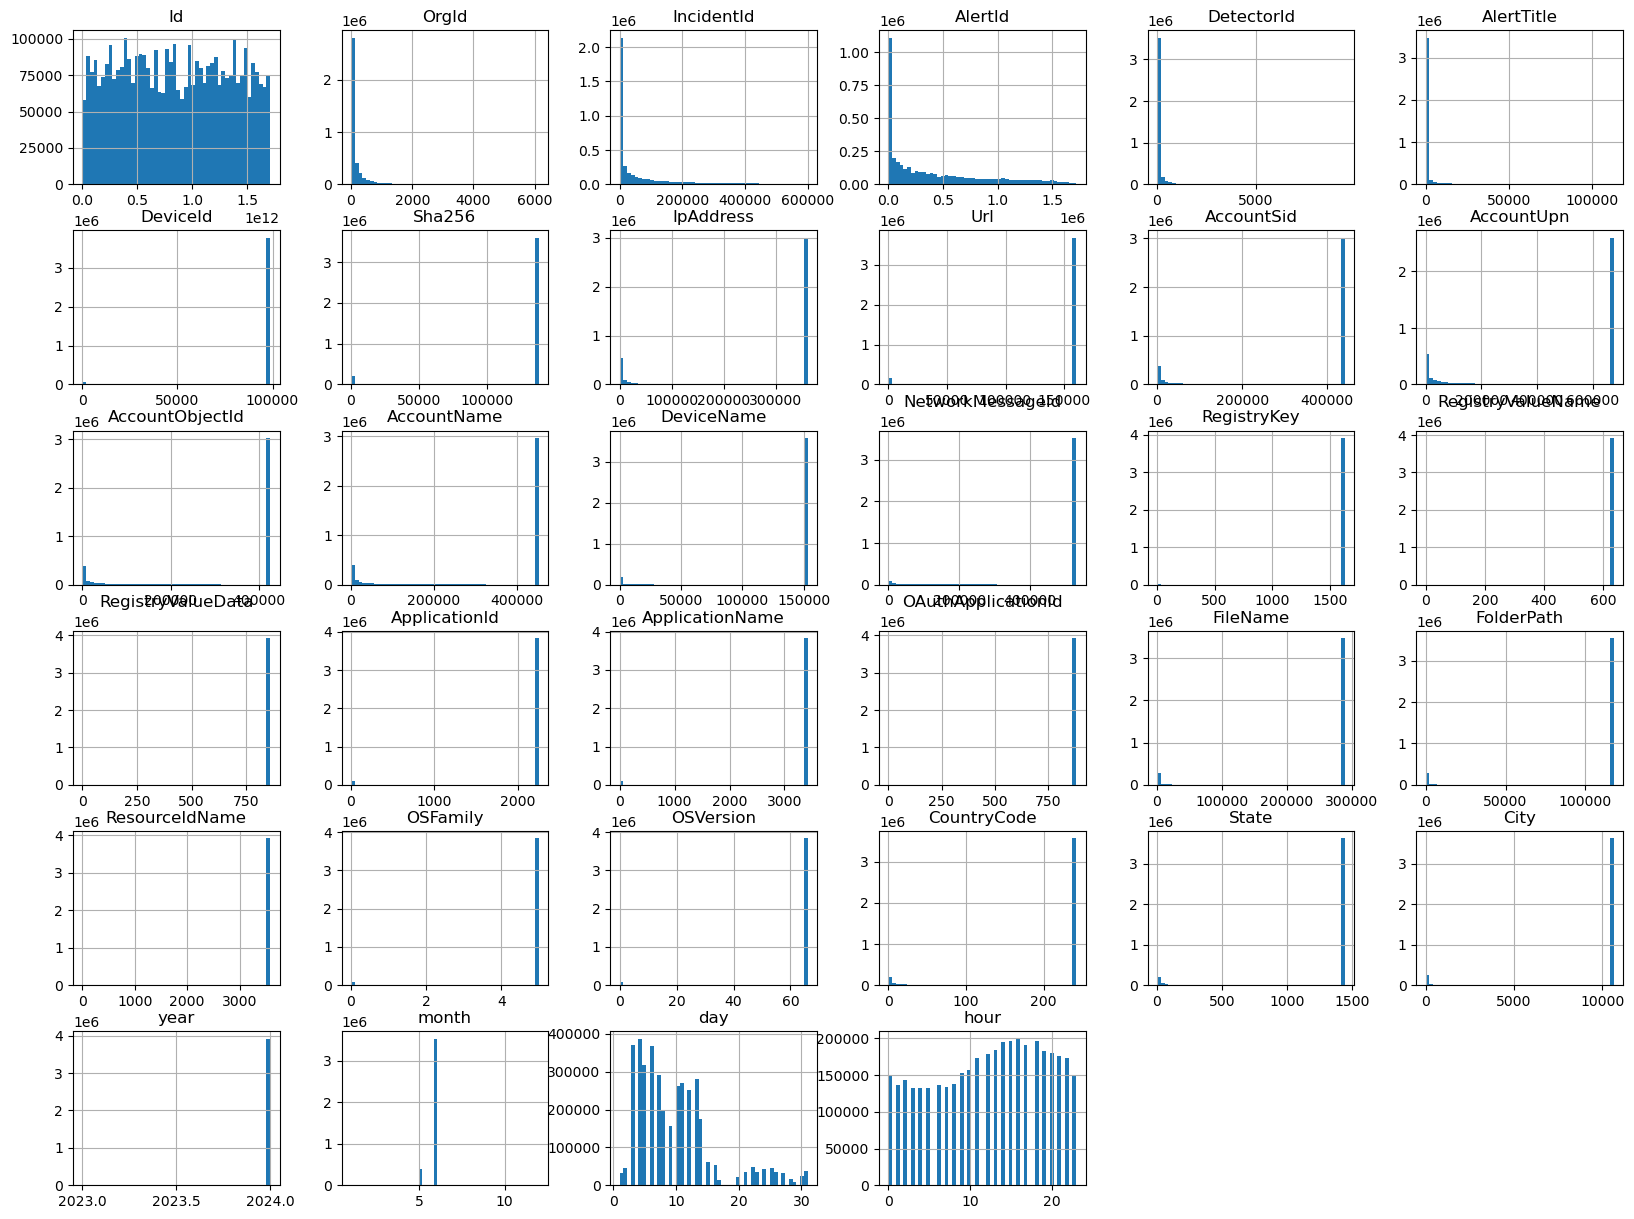

In [56]:
#plotting distribution
test_data.hist(bins=50, figsize=(20,15))
plt.show()

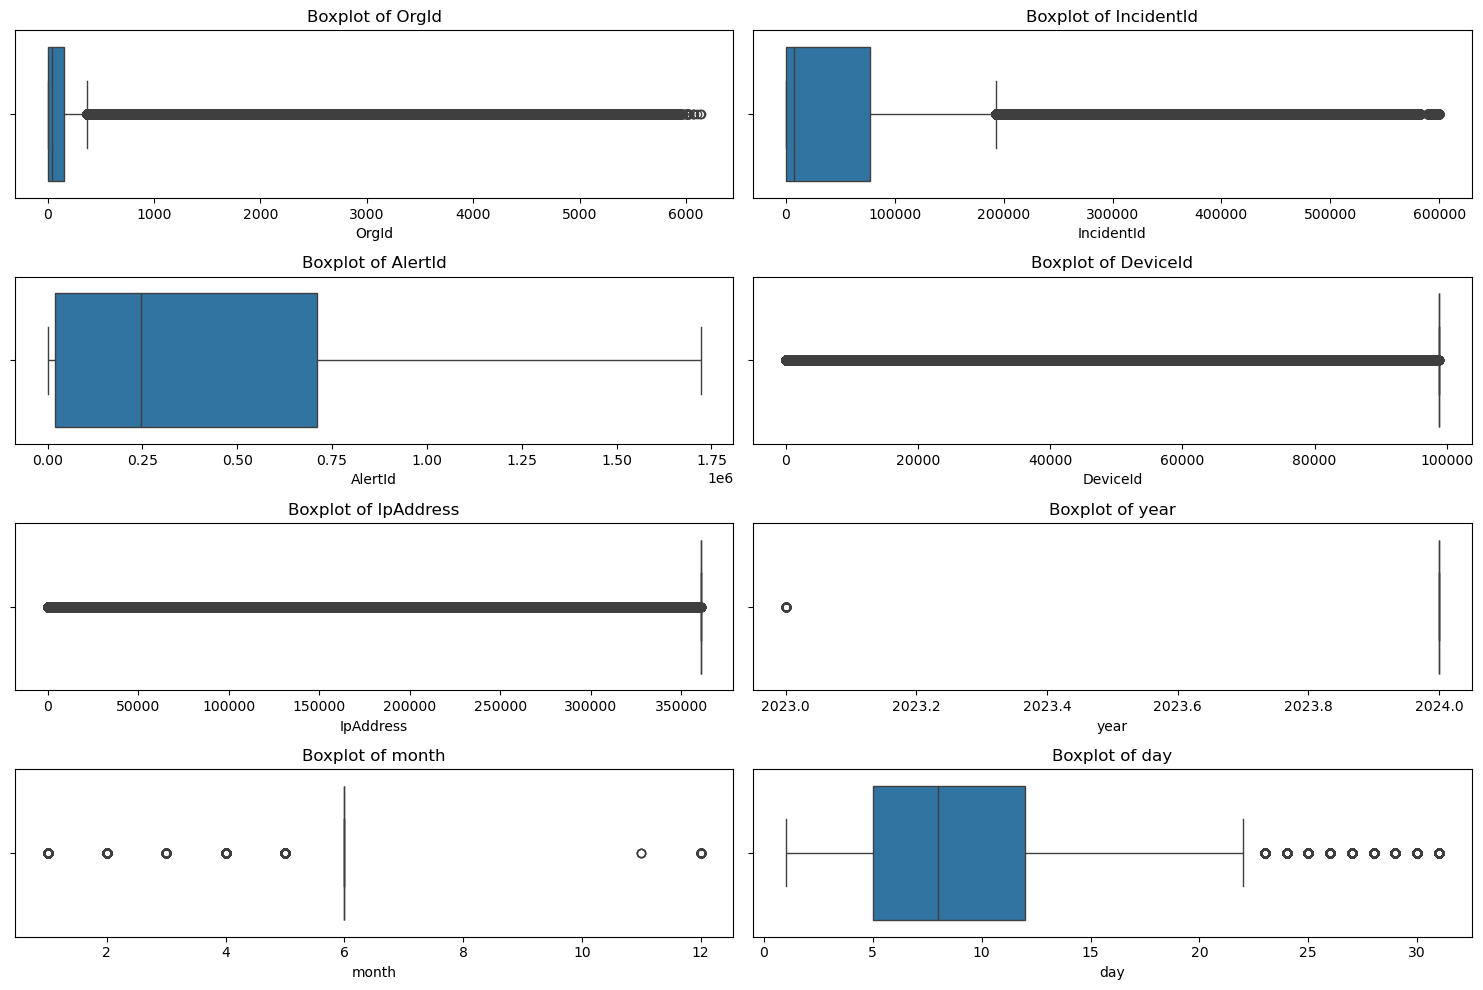

In [57]:
#plotting boxplot for outliers
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'year', 'month', 'day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [58]:
# Corelation matrix
numeric_cols = test_data.select_dtypes(include=[np.number])


correlation_matrix = numeric_cols.corr()



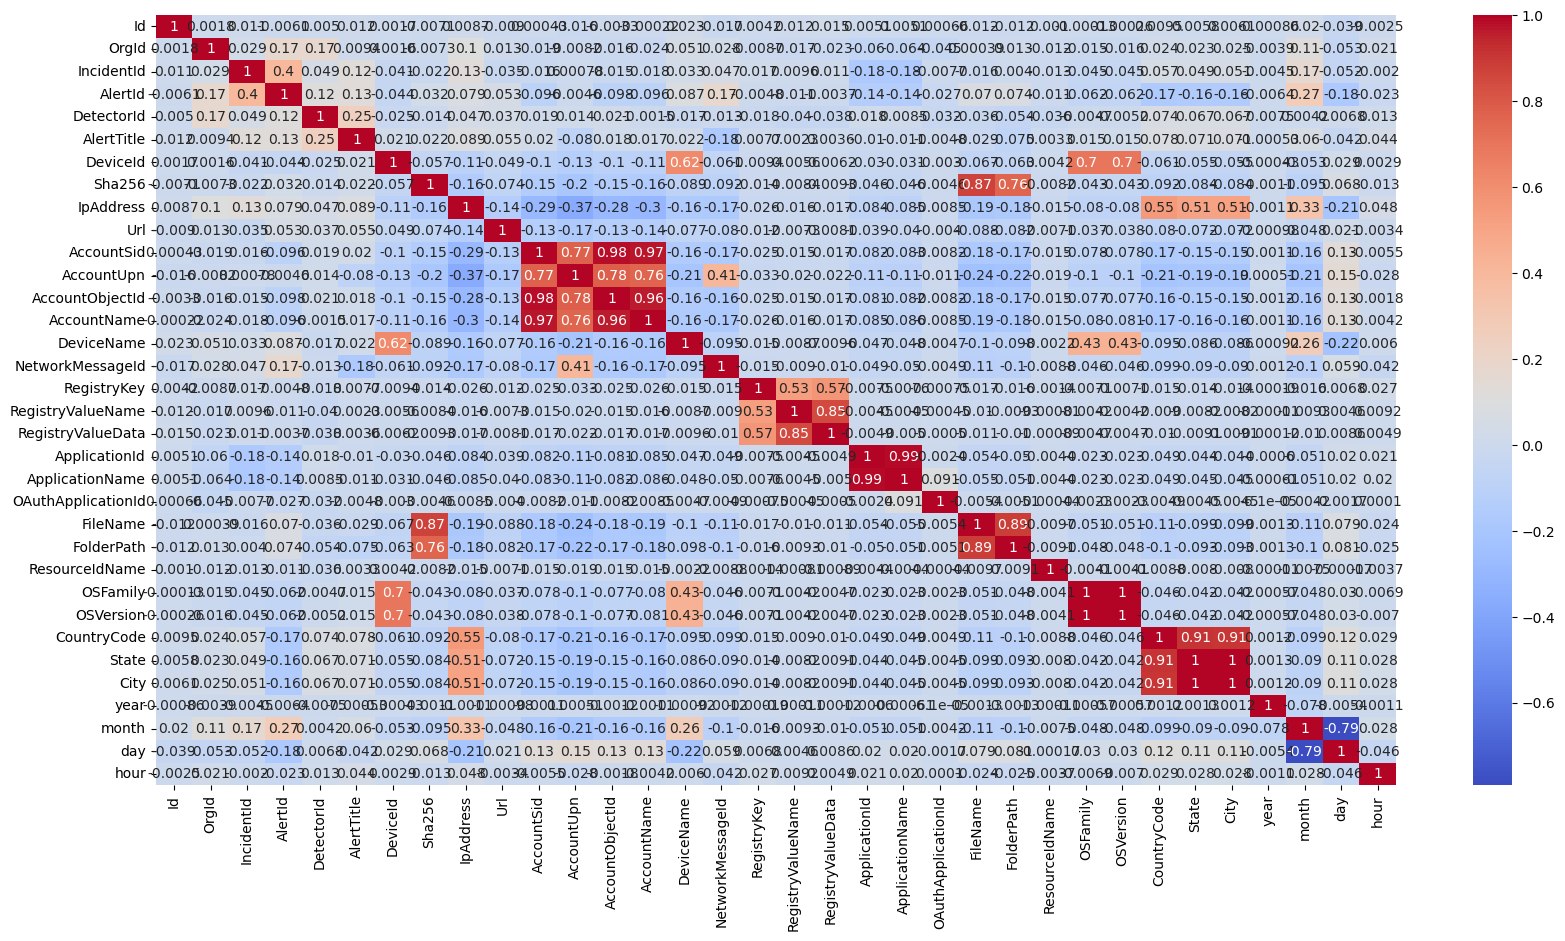

In [59]:
#plotting corelation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.show()

Feature importance

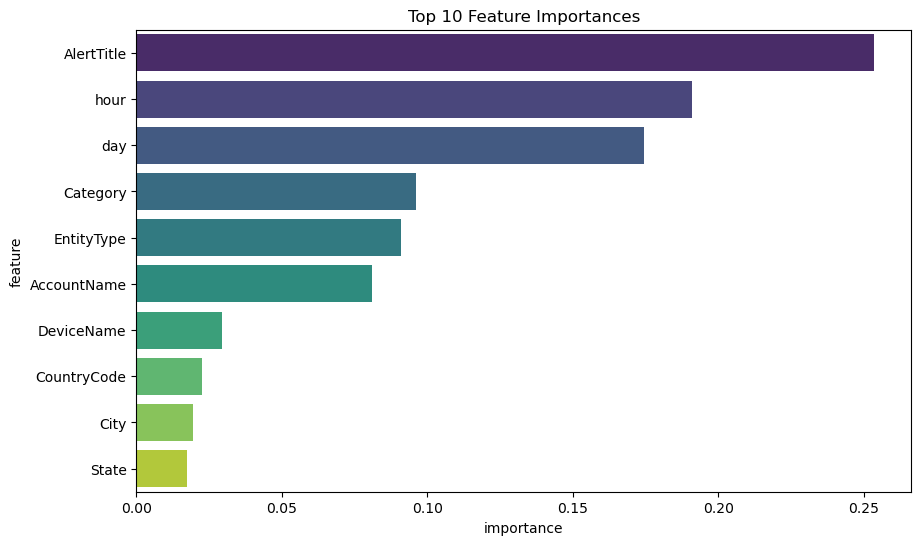

In [60]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']
test_sample = test_data.sample(frac=0.001, random_state=42)
X = test_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = test_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10),palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

In [61]:
columns_to_drop = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256','IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId','BlockingIOErrorDeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [62]:
test_data.columns   # columns in the dataset

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City',
       'year', 'month', 'day', 'hour'],
      dtype='object')

In [63]:
test_data.shape # shape of the dataset

(3922695, 15)

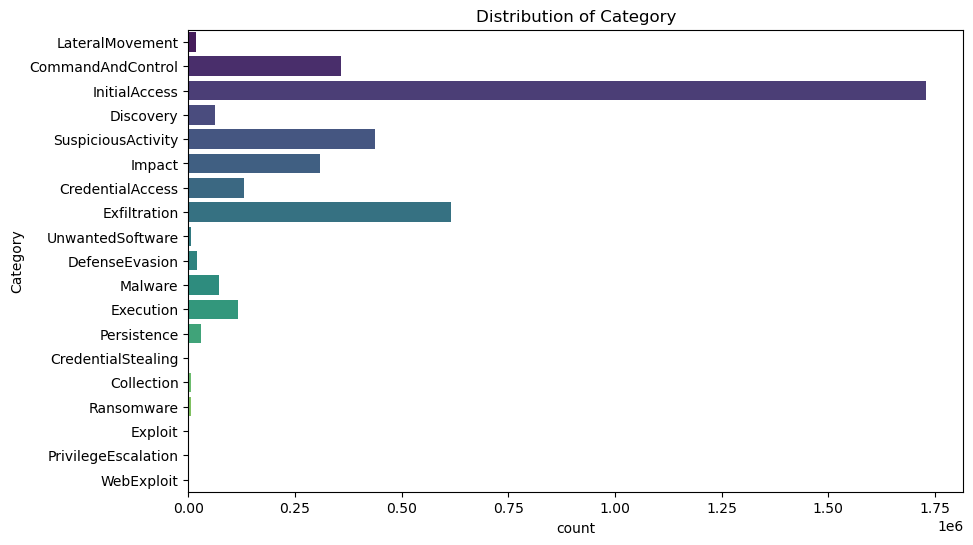

In [64]:
#plotting the distribution of category
plt.figure(figsize=(10,6))
sns.countplot(test_data['Category'], palette='viridis')
plt.title('Distribution of Category')
plt.show()

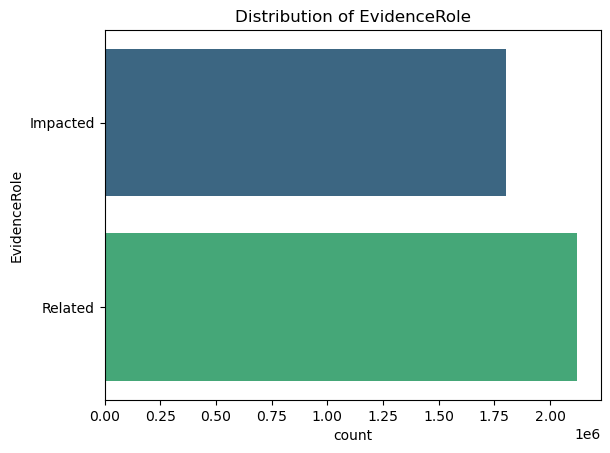

In [65]:
#plotting the distribution of evidence Role
sns.countplot(test_data['EvidenceRole'], palette='viridis')
plt.title('Distribution of EvidenceRole')
plt.show()

In [66]:
# Columns to drop based on correlation and feature importance
columns_to_drop = ['City', 'State']

# Drop selected columns
test_data = test_data.drop(columns=columns_to_drop)

print("Dropped columns due to high correlation and lower feature importance:", columns_to_drop)

test_data.head() # first 5 rows of the dataset

Dropped columns due to high correlation and lower feature importance: ['City', 'State']


,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour
0,563,LateralMovement,BenignPositive,User,Impacted,863,153085,5,242,2024,6,4,22
1,2,CommandAndControl,BenignPositive,Machine,Impacted,453297,2833,0,242,2024,6,3,12
2,10807,LateralMovement,BenignPositive,Process,Related,453297,153085,5,242,2024,6,8,3
3,0,InitialAccess,FalsePositive,CloudLogonSession,Related,453297,153085,5,242,2024,6,12,12
4,18,Discovery,BenignPositive,User,Impacted,136104,153085,5,242,2024,6,6,17


In [67]:
test_data.shape # shape of the dataset

(3922695, 13)

In [68]:
test_data.nunique() # unique values in each column

AlertTitle        42265
Category             19
IncidentGrade         3
EntityType           29
EvidenceRole          2
AccountName      222314
DeviceName        74791
OSFamily              5
CountryCode         212
year                  2
month                 8
day                  31
hour                 24
dtype: int64

In [69]:
test_data['Category'].value_counts() # value counts of the category column

Category
InitialAccess          1730207
Exfiltration            615278
SuspiciousActivity      438875
CommandAndControl       357143
Impact                  307809
CredentialAccess        130133
Execution               115651
Malware                  71083
Discovery                63605
Persistence              29063
DefenseEvasion           21556
LateralMovement          18897
UnwantedSoftware          7467
Collection                6267
Ransomware                5581
Exploit                   1644
PrivilegeEscalation       1552
CredentialStealing         873
WebExploit                  11
Name: count, dtype: int64

In [70]:
test_data['EvidenceRole'].value_counts() # value counts of the EvidenceRole column

EvidenceRole
Related     2121700
Impacted    1800995
Name: count, dtype: int64

In [71]:
test_data['EntityType'].value_counts() # value counts of the EntityType column

EntityType
Ip                       929595
User                     830856
MailMessage              406884
Machine                  348065
CloudLogonRequest        298654
File                     288827
Url                      254267
Process                  164740
Mailbox                  147542
CloudLogonSession         94462
CloudApplication          94331
MailCluster               45654
RegistryValue              6771
AzureResource              3363
RegistryKey                2925
GenericEntity              2132
Malware                    1742
OAuthApplication           1041
BlobContainer               240
SecurityGroup               234
Blob                        219
MailboxConfiguration         93
Nic                          30
IoTDevice                    20
ActiveDirectoryDomain         4
KubernetesNamespace           1
KubernetesCluster             1
GoogleCloudResource           1
AmazonResource                1
Name: count, dtype: int64

In [72]:
#Capping outliers using quantiles and log transformation

def handle_outliers(df):
    # Define columns where quantile capping will be applied
    capped_columns = ['AlertId']
    
    # Check if columns exist before applying quantile capping
    for col in capped_columns:
        if col in df.columns:
            q_low = df[col].quantile(0.01)
            q_high = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=q_low, upper=q_high)
    
    # Optional log transformation for skewed fields, if needed
    for col in capped_columns:
        if col in df.columns and df[col].skew() > 1:
            df[col] = np.log1p(df[col])  # log1p to handle zero values safely
            
    return df

# Apply outlier handling
test_data = handle_outliers(test_data)
   

In [73]:
# Identify categorical columns
categorical_columns = ['IncidentGrade', 'EvidenceRole', 'Category', 'EntityType']

# Check if columns exist before applying one-hot encoding
columns_to_encode = [col for col in ['Category', 'EntityType', 'EvidenceRole'] if col in test_data.columns]

# Apply one-hot encoding or label encoding only to categorical columns
# One-hot encoding for non-ordinal categorical columns
if columns_to_encode:
    test_data = pd.get_dummies(test_data, columns=columns_to_encode, drop_first=True)

# Label encoding for ordinal categorical column if it has an order
if 'IncidentGrade' in test_data.columns:
    le = LabelEncoder()
    test_data['IncidentGrade'] = le.fit_transform(test_data['IncidentGrade'])

# Apply frequency encoding only to high-cardinality categorical features
frequency_encoding = test_data['AlertTitle'].value_counts(normalize=True)
test_data['AlertTitle_encoded'] = test_data['AlertTitle'].map(frequency_encoding)

# Now test_data has encoded categorical columns, and numerical columns are untouched
test_data.head()

,AlertTitle,IncidentGrade,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour,...,EntityType_Nic,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Related,AlertTitle_encoded
0,563,0,863,153085,5,242,2024,6,4,22,...,False,False,False,False,False,False,False,True,False,0.000105
1,2,0,453297,2833,0,242,2024,6,3,12,...,False,False,False,False,False,False,False,False,False,0.066806
2,10807,0,453297,153085,5,242,2024,6,8,3,...,False,False,True,False,False,False,False,False,True,0.000005
3,0,1,453297,153085,5,242,2024,6,12,12,...,False,False,False,False,False,False,False,False,True,0.154600
4,18,0,136104,153085,5,242,2024,6,6,17,...,False,False,False,False,False,False,False,True,False,0.008225


In [74]:
#Saving the cleaned dataset as joblib file
import joblib
joblib.dump(test_data, 'encoded_test_data.joblib')
print("Data cleaning completed and saved as encoded_test_data.joblib")




Data cleaning completed and saved as encoded_test_data.joblib


In [75]:
#Loading the cleaned dataset
test_data = joblib.load('encoded_test_data.joblib')
test_data.head()

,AlertTitle,IncidentGrade,AccountName,DeviceName,OSFamily,CountryCode,year,month,day,hour,...,EntityType_Nic,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Related,AlertTitle_encoded
0,563,0,863,153085,5,242,2024,6,4,22,...,False,False,False,False,False,False,False,True,False,0.000105
1,2,0,453297,2833,0,242,2024,6,3,12,...,False,False,False,False,False,False,False,False,False,0.066806
2,10807,0,453297,153085,5,242,2024,6,8,3,...,False,False,True,False,False,False,False,False,True,0.000005
3,0,1,453297,153085,5,242,2024,6,12,12,...,False,False,False,False,False,False,False,False,True,0.154600
4,18,0,136104,153085,5,242,2024,6,6,17,...,False,False,False,False,False,False,False,True,False,0.008225
